🇪🇺 Arne Krueger and Chad G. Petey Presents 🤓: 
# 🦅 Arne Krueger's Fun 🎉 with 📚 Patent Classifikation ✨

## Welcome, Patent Information Professionals- this is Session 4!

Patent classification systems, like the Cooperative Patent Classification (CPC), are essential tools for organizing, searching, and analyzing patent information. CPC data provides hierarchical insights into technology fields, from broad sections to detailed subgroups. 

This notebook is a hands-on guide to **download, parse, and analyze CPC data, based on XML files provided by USPTO and the Cooperative Classification Website**. Whether you're a patent professional, data scientist, or simply curious about the structure of CPC, this is your starting point for transforming CPC text data into meaningful insights.

The CPC system is hierarchical, providing insights from broad sections to granular subgroups, up to 19 level deep. In this notebook, we explore how to download, parse, and analyze CPC XML data to create a structured database for further analysis.

### What We'll Cover
1. **Downloading CPC Schema XSD**: Access the latest CPC classification data, the defintion of the XML
2. **Downloading CPC Schema XML**: Access the content, here as a zip with 687 XMls one per each subgroup.

3. **Parsing XML Tree to access its content**: Create pandas DataFrames from raw CPC XML files.

4. **Analyzing CPC Data**: Prepare the data for visualization and queries.

## Step 1 - Setup: Import Libraries and Define Functions for XML File handling

### 🚀 Download the XSD Schema
First, import the libraries, then create a function to download the CPC XSD Schema. This CPC schema ensures the validity of XML files. 

In [12]:
import os
import requests
import zipfile
import pandas as pd
from lxml import etree
import sqlite3
import matplotlib.pyplot as plt
import time

def download_xsd(destination_folder="./cpc_xml"):
    """Download the CPC XSD schema."""
    xsd_url = "https://www.cooperativepatentclassification.org/sites/default/files/attachments/b0cebc06-677b-4243-9c9a-adf7300b979f/CPCSchemeSchema17.xsd"
    os.makedirs(destination_folder, exist_ok=True)
    xsd_file_path = os.path.join(destination_folder, "CPCSchemeSchema17.xsd")

    if not os.path.exists(xsd_file_path):
        print(f"Downloading XSD schema from {xsd_url}...")
        response = requests.get(xsd_url)
        response.raise_for_status()
        with open(xsd_file_path, "wb") as f:
            f.write(response.content)
        print(f"Downloaded XSD schema to {xsd_file_path}")
    else:
        print(f"XSD file already exists: {xsd_file_path}")

    return xsd_file_path

### 📂 Download CPC XML Data

Download and Extract CPC XML Files

This function downloads the CPC Scheme XML files and extracts them into a specified folder.

In [13]:

def download_and_extract_cpc_scheme_xml(url, destination_folder="./cpc_xml"):
    """Download and extract CPC Scheme XML ZIP file."""
    os.makedirs(destination_folder, exist_ok=True)
    zip_file_path = os.path.join(destination_folder, "CPCSchemeXML.zip")

    if not os.path.exists(zip_file_path):
        print(f"Downloading {url}...")
        response = requests.get(url)
        response.raise_for_status()
        with open(zip_file_path, "wb") as f:
            f.write(response.content)
        print(f"Downloaded to {zip_file_path}")
    else:
        print(f"ZIP file already exists: {zip_file_path}")

    print("Extracting the ZIP file...")
    with zipfile.ZipFile(zip_file_path, "r") as zip_ref:
        zip_ref.extractall(destination_folder)
        extracted_files = zip_ref.namelist()

    xml_files = [os.path.join(destination_folder, f) for f in extracted_files if f.endswith(".xml")]
    print(f"Total XML files extracted: {len(xml_files)}")
    return xml_files


## Step 2 - Data Pipeline

### 🛠️ Parsing and Validating

We define a function to create a datframe with the CPC. 

For that parse the tree, symbol, level and title and add this to a data frame.

In [14]:

def parse_cpc_scheme_xml(xml_file_path, xsd_file_path=None):
    """Parses the CPC Scheme XML file and extracts classification items."""
    try:
        tree = etree.parse(xml_file_path)
    except Exception as e:
        print(f"Error parsing XML file {xml_file_path}: {e}")
        return pd.DataFrame(), 0, 0

    root = tree.getroot()
    items = root.findall('.//classification-item')
    total_items = len(items)
    skipped_items = 0
    data = []

    for item in items:
        classification_symbol = item.findtext('classification-symbol')
        level = item.get('level')
        title_parts = item.findall('.//title-part/text')
        full_title = " > ".join("".join(part.itertext()).strip() for part in title_parts if part is not None)

        if not classification_symbol or not full_title:
            skipped_items += 1
            continue

        data.append({
            'classification_symbol': classification_symbol,
            'level': level,
            'full_title': full_title
        })

    return pd.DataFrame(data), total_items, skipped_items



## Step 3 - Results and Insights

### 🔍 Execute the main workflow 

That calls the functions and creates the pandas dataframe  . Final Dataset Overview 

In [19]:
if __name__ == "__main__":

    # Start the timer
    start_time = time.time()
   
    # Configuration
    cpc_zip_url = "https://www.cooperativepatentclassification.org/sites/default/files/cpc/bulk/CPCSchemeXML202408.zip"
    destination_folder = "./cpc_xml"

    # Download and extract XML files
    xml_files = download_and_extract_cpc_scheme_xml(cpc_zip_url, destination_folder)

    all_classifications = pd.DataFrame()
    total_files = len(xml_files)
    total_items = 0
    total_skipped = 0

    for xml_file in xml_files:
        df, items, skipped = parse_cpc_scheme_xml(xml_file)
        if not df.empty:
            all_classifications = pd.concat([all_classifications, df], ignore_index=True)
        total_items += items
        total_skipped += skipped


    # Stop the timer
    end_time = time.time()
    # Calculate and print the execution time
    execution_time = end_time - start_time

    print(f"\nProcessed {total_files} XML files in: {execution_time:.2f} seconds")
    print(f"Total classification items found: {total_items}")
    print(f"Total items skipped: {total_skipped}")
    
    print(" ")
    print("The first 5 entries of the extracted data frame:")
    print(all_classifications.head())
    

ZIP file already exists: ./cpc_xml/CPCSchemeXML.zip
Extracting the ZIP file...
Total XML files extracted: 687

Processed 687 XML files in: 8.06 seconds
Total classification items found: 263308
Total items skipped: 102657
 
The first 5 entries of the extracted data frame:
  classification_symbol level  \
0                     A     2   
1                   A01     3   
2                   A01     4   
3                  A01B     5   
4                  A01C     5   

                                          full_title  
0  HUMAN NECESSITIES > AGRICULTURE > AGRICULTURE ...  
1  AGRICULTURE > AGRICULTURE > FORESTRY > ANIMAL ...  
2  AGRICULTURE > FORESTRY > ANIMAL HUSBANDRY > HU...  
3  SOIL WORKING IN AGRICULTURE OR FORESTRY > PART...  
4                    PLANTING > SOWING > FERTILISING  
  classification_symbol level                            full_title
0                     A     2                     HUMAN NECESSITIES
1                     B     2  PERFORMING OPERATIONS > TRANSPOR

### 📊 Data Visualization

Additional analysis and vizualisation, e.g. plot a chart for Classification Levels Distribution

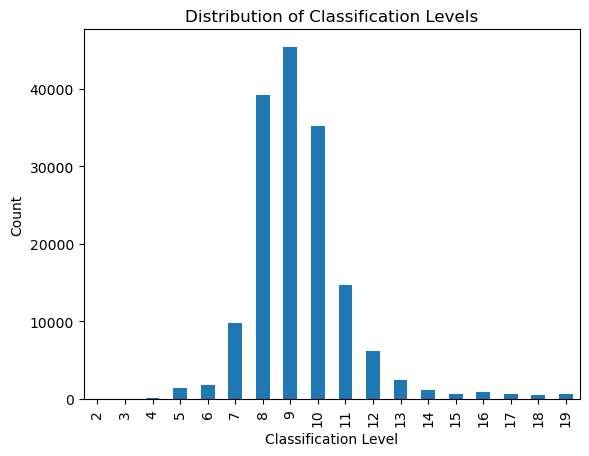

In [7]:

if not all_classifications.empty:
    all_classifications['level'] = all_classifications['level'].astype(int)
    all_classifications['level'].value_counts().sort_index().plot(kind='bar')
    plt.title("Distribution of Classification Levels")
    plt.xlabel("Classification Level")
    plt.ylabel("Count")
    plt.show()



### 📊 SQL Query Example: Titles with “SOIL”

In [21]:

    conn = sqlite3.connect(":memory:")
    all_classifications.to_sql("cpc_classification", conn, index=False, if_exists="replace")

    query = "SELECT * FROM cpc_classification WHERE full_title LIKE '%ELEVATORS%'"
    df_query = pd.read_sql_query(query, conn)
    print("\nExample query result:")
    print(df_query)

    conn.close()



Example query result:
   classification_symbol level  \
0                   A01D     5   
1              A01D57/00     6   
2              A01D61/00     7   
3                      B     2   
4                    B60     3   
..                   ...   ...   
72           G10K2210/10     8   
73          G10K2210/113     9   
74                  Y02B     5   
75             Y02B10/00     6   
76             Y02B50/00     7   

                                           full_title  
0   HARVESTING > MOWING > Hand implements > Hand-c...  
1   Components of harvesters or mowers for grass o...  
2   Elevators or conveyors for binders or combines...  
3   PERFORMING OPERATIONS > TRANSPORTING > SEPARAT...  
4   TRANSPORTING > VEHICLES IN GENERAL > VEHICLE W...  
..                                                ...  
72  Applications > One dimensional > Two dimension...  
73                                          Elevators  
74  CLIMATE CHANGE MITIGATION TECHNOLOGIES RELATED...  
75  Inte

## ✅ Conclusions and Next Steps

This notebook demonstrates how to process CPC classification data. By structuring and visualizing the data, we can draw valuable insights from patent classifications.

We hope you found this guide useful! Share your thoughts, ideas, or any questions with us on LinkedIn or in the community. Let’s continue exploring the exciting world of patent information! 🚀

### Appendix
Complete code block with all the functions and vizualisation

In [ ]:
import os
import requests
import zipfile
import pandas as pd
from lxml import etree
import sqlite3

def download_xsd(destination_folder="./cpc_xml"):
    """Download the CPC XSD schema."""
    xsd_url = "https://www.cooperativepatentclassification.org/sites/default/files/attachments/b0cebc06-677b-4243-9c9a-adf7300b979f/CPCSchemeSchema17.xsd"
    os.makedirs(destination_folder, exist_ok=True)
    xsd_file_path = os.path.join(destination_folder, "CPCSchemeSchema17.xsd")

    if not os.path.exists(xsd_file_path):
        print(f"Downloading XSD schema from {xsd_url}...")
        response = requests.get(xsd_url)
        response.raise_for_status()
        with open(xsd_file_path, "wb") as f:
            f.write(response.content)
        print(f"Downloaded XSD schema to {xsd_file_path}")
    else:
        print(f"XSD file already exists: {xsd_file_path}")

    return xsd_file_path

def download_and_extract_cpc_scheme_xml(url, destination_folder="./cpc_xml"):
    """Download and extract CPC Scheme XML ZIP file."""
    os.makedirs(destination_folder, exist_ok=True)
    zip_file_path = os.path.join(destination_folder, "CPCSchemeXML.zip")

    # Step 1: Download the ZIP file
    if not os.path.exists(zip_file_path):
        print(f"Downloading {url}...")
        response = requests.get(url)
        response.raise_for_status()
        with open(zip_file_path, "wb") as f:
            f.write(response.content)
        print(f"Downloaded to {zip_file_path}")
    else:
        print(f"ZIP file already exists: {zip_file_path}")

    # Step 2: Extract the ZIP file
    print("Extracting the ZIP file...")
    with zipfile.ZipFile(zip_file_path, "r") as zip_ref:
        zip_ref.extractall(destination_folder)
        extracted_files = zip_ref.namelist()

    # Step 3: Filter XML files
    xml_files = [os.path.join(destination_folder, f) for f in extracted_files if f.endswith(".xml")]
    print(f"Total XML files extracted: {len(xml_files)}")
    return xml_files
    
def parse_cpc_scheme_xml(xml_file_path, xsd_file_path=None):
    """
    Parses the CPC Scheme XML file and extracts classification items.

    Parameters:
        xml_file_path (str): Path to the XML file.
        xsd_file_path (str): Path to the XSD schema file for validation (optional).

    Returns:
        pd.DataFrame: DataFrame containing parsed CPC classification items.
        int: Total items found.
        int: Total items skipped.
    """
    # Parse the XML file
    try:
        tree = etree.parse(xml_file_path)
    except Exception as e:
        print(f"Error parsing XML file {xml_file_path}: {e}")
        return pd.DataFrame(), 0, 0

    root = tree.getroot()

    # Extract classification items
    items = root.findall('.//classification-item')
    total_items = len(items)
    skipped_items = 0

    data = []

    for item in items:
        classification_symbol = item.findtext('classification-symbol')
        level = item.get('level')

        # Extract title parts and concatenate them into a single title
        title_parts = item.findall('.//title-part/text')
        full_title = " > ".join("".join(part.itertext()).strip() for part in title_parts if part is not None)

        # Skip entries without a classification-symbol or title
        if not classification_symbol or not full_title:
            skipped_items += 1
            continue

        # Append extracted data
        data.append({
            'classification_symbol': classification_symbol,
            'level': level,
            'full_title': full_title
        })

    return pd.DataFrame(data), total_items, skipped_items

def download_and_extract_cpc_scheme_xml(url, destination_folder="./cpc_xml"):
    """
    Downloads and extracts the CPC Scheme XML ZIP file.

    Parameters:
        url (str): URL to the CPC Scheme XML ZIP file.
        destination_folder (str): Folder to save the downloaded and extracted files.

    Returns:
        list: List of extracted XML file paths.
    """
    os.makedirs(destination_folder, exist_ok=True)
    zip_file_path = os.path.join(destination_folder, "CPCSchemeXML.zip")

    if not os.path.exists(zip_file_path):
        print(f"Downloading {url}...")
        response = requests.get(url)
        response.raise_for_status()
        with open(zip_file_path, "wb") as f:
            f.write(response.content)
        print(f"Downloaded to {zip_file_path}")
    else:
        print(f"ZIP file already exists: {zip_file_path}")

    print("Extracting the ZIP file...")
    with zipfile.ZipFile(zip_file_path, "r") as zip_ref:
        zip_ref.extractall(destination_folder)
        extracted_files = zip_ref.namelist()

    xml_files = [os.path.join(destination_folder, f) for f in extracted_files if f.endswith(".xml")]
    print(f"Total XML files extracted: {len(xml_files)}")
    return xml_files

if __name__ == "__main__":
    # Configuration
    cpc_zip_url = "https://www.cooperativepatentclassification.org/sites/default/files/cpc/bulk/CPCSchemeXML202408.zip"
    destination_folder = "./cpc_xml"

    # Download and extract XML files
    xml_files = download_and_extract_cpc_scheme_xml(cpc_zip_url, destination_folder)

    # Initialize an empty DataFrame
    all_classifications = pd.DataFrame()

    # Parse each XML file
    total_files = len(xml_files)
    total_items = 0
    total_skipped = 0

    for i, xml_file in enumerate(xml_files, 1):
        df, items, skipped = parse_cpc_scheme_xml(xml_file)
        if not df.empty:
            all_classifications = pd.concat([all_classifications, df], ignore_index=True)
        total_items += items
        total_skipped += skipped

    # Final summary
    print(f"\nProcessed {total_files} XML files.")
    print(f"Total classification items found: {total_items}")
    print(f"Total items skipped: {total_skipped}")

    if not all_classifications.empty:
        print(f"Total classifications extracted: {len(all_classifications)}")
        print("Sample data:")
        print(all_classifications.head())

        # Save the DataFrame to SQLite
        conn = sqlite3.connect(":memory:")
        all_classifications.to_sql("cpc_classification", conn, index=False, if_exists="replace")
        print("\nSaved to in-memory SQLite database.")

        # Example query
        query = "SELECT * FROM cpc_classification WHERE full_title LIKE '%SOIL%'"
        df_query = pd.read_sql_query(query, conn)
        print("\nExample query result:")
        print(df_query)

        conn.close()
    else:
        print("No data extracted. Check XML parsing logic or file structure.")

